# **Link Github Data Set**



In [1]:
!git clone https://github.com/Hrushi11/Real-TIme-Skin-Type-Detection.git

Cloning into 'Real-TIme-Skin-Type-Detection'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 548 (delta 0), reused 3 (delta 0), pack-reused 545
Receiving objects: 100% (548/548), 234.11 MiB | 8.06 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (541/541), done.


In [2]:
#Create a local folder to store images
import os
import shutil
src_dir ='/content/Real-TIme-Skin-Type-Detection/skin-dataset/oily'
datafile = '/content/datafile' #create a folder to move images in repository
files = os.listdir(src_dir)
shutil.copytree(src_dir, datafile)

'/content/datafile'

# **Image Augmentation**

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tqdm import tqdm
import os

# Specify the directory containing your original images
original_data_dir = '/content/datafile'

# Specify the directory to save augmented images
augmented_data_dir = '/content/augmented_images'

# Create the augmented images directory if it doesn't exist
if not os.path.exists(augmented_data_dir):
    os.makedirs(augmented_data_dir)

# Create an ImageDataGenerator instance
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Get a list of image file names in the original images directory
original_images = [f for f in os.listdir(original_data_dir) if os.path.isfile(os.path.join(original_data_dir, f))]

# Loop through each original image, generate augmented images, and save them
for original_image_name in tqdm(original_images, desc="Augmenting images"):
    # Load the original image
    original_img_path = os.path.join(original_data_dir, original_image_name)
    img = image.load_img(original_img_path)
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_data_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= 10:  # Save 10 augmented images for each original image
            break


Augmenting images: 100%|██████████| 143/143 [05:58<00:00,  2.51s/it]


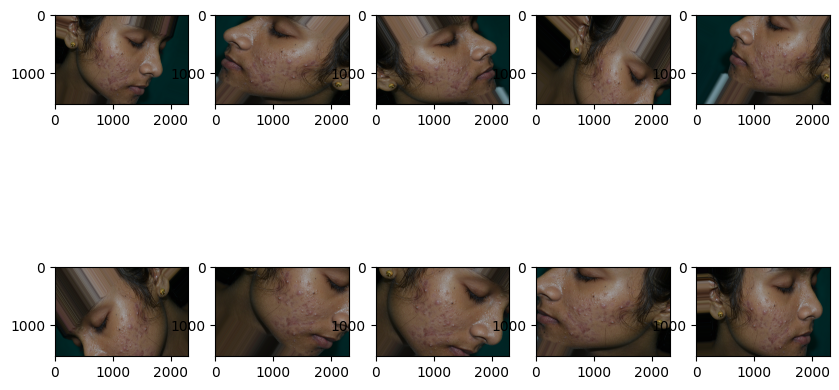

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Assuming x is your input data for the generator
# datagen = YourImageDataGenerator()

# Generate augmented images and display them
plt.figure(figsize=(10, 6))
i = 0

for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2, 5, i+1)  # Assuming 2 rows and 5 columns for a total of 10 subplots
    plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 10:
        break  # Break after displaying 10 augmented images

plt.show()



# features extraction

In [5]:
!git clone https://github.com/mpatacchiola/deepgaze.git

Cloning into 'deepgaze'...
remote: Enumerating objects: 1324, done.
remote: Total 1324 (delta 0), reused 0 (delta 0), pack-reused 1324
Receiving objects: 100% (1324/1324), 239.15 MiB | 8.23 MiB/s, done.
Resolving deltas: 100% (733/733), done.
Updating files: 100% (170/170), done.


In [6]:
!pip install /content/deepgaze

Processing ./deepgaze
  Preparing metadata (setup.py) ... done
  Created wheel for deepgaze: filename=deepgaze-0.1-py3-none-any.whl size=40413 sha256=7a3f1d0d486328f2902f6fa0fc5abd660efe129c365e7dcb17c4dc85135d5ab8
  Stored in directory: /tmp/pip-ephem-wheel-cache-1b8lofe4/wheels/06/cb/99/3f1cfaa91774996b3acd87bf32f415e5e536ed238eb3ededb2
Successfully built deepgaze


In [7]:
from deepgaze.color_detection import RangeColorDetector

Processing batches: 100%|██████████| 14/14 [04:29<00:00, 19.27s/it]


Features and image names saved to extracted_features.csv
Skin-detected images saved to /content/extracted_feature_images


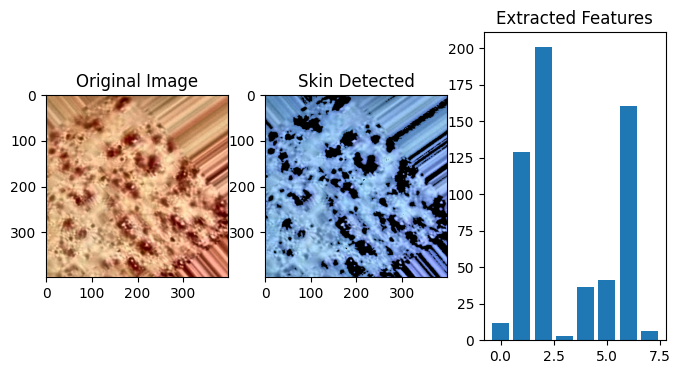

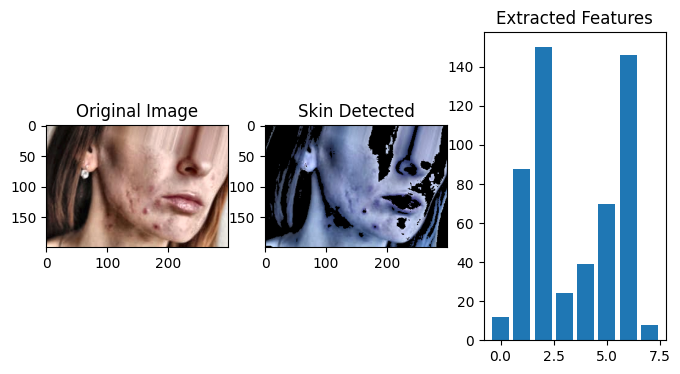

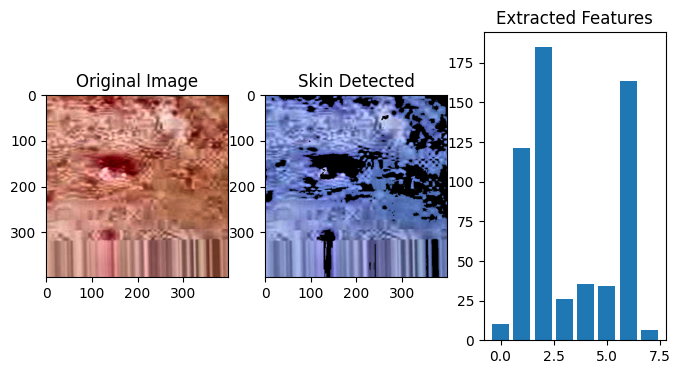

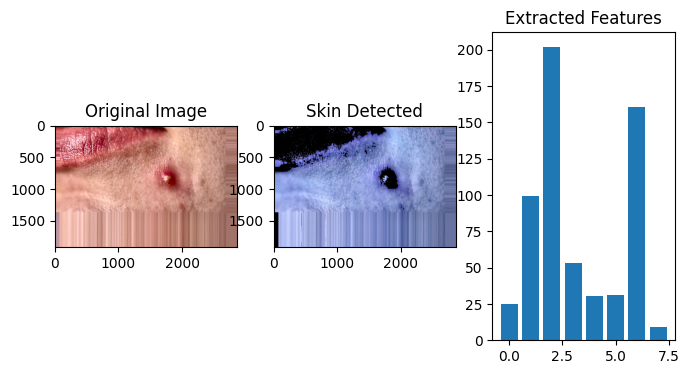

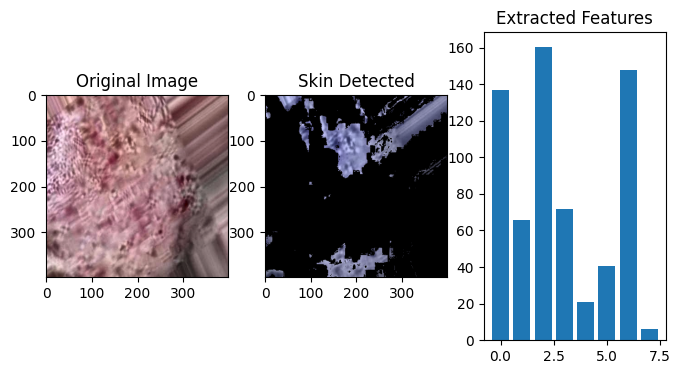

In [8]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the RangeColorDetector class for skin color detection
class RangeColorDetector:
    def __init__(self, min_range, max_range):
        self.min_range = min_range
        self.max_range = max_range

    def returnFiltered(self, image, morph_opening=False, blur=False, kernel_size=3, iterations=1):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        skin_mask = cv2.inRange(hsv, self.min_range, self.max_range)

        # Optionally apply morphological opening
        if morph_opening:
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel, iterations=iterations)

        # Optionally apply blur
        if blur:
            skin_mask = cv2.GaussianBlur(skin_mask, (kernel_size, kernel_size), 0)

        # Apply the mask to the original image
        skin_detected = cv2.bitwise_and(image, image, mask=skin_mask)

        return skin_detected

# Function to extract color-based features
def extract_color_features(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the mean and standard deviation of each channel
    mean_hsv = np.mean(hsv, axis=(0, 1))
    std_hsv = np.std(hsv, axis=(0, 1))

    # Concatenate mean and std to form feature vector
    color_features = np.concatenate((mean_hsv, std_hsv))

    return color_features

# Function to extract skin reflection features
def extract_skin_reflection_features(image):
    # Convert the image to YCbCr color space
    ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Extract the Cr (chrominance) channel
    cr_channel = ycbcr[:,:,1]

    # Calculate the mean and standard deviation of the Cr channel
    mean_cr = np.mean(cr_channel)
    std_cr = np.std(cr_channel)

    # Concatenate mean and std to form feature vector
    skin_reflection_features = np.array([mean_cr, std_cr])

    return skin_reflection_features

# Function to enhance skin texture using CLAHE
def enhance_skin_texture(image):
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Extract the L (luminance) channel
    l_channel = lab[:,:,0]

    # Apply CLAHE to enhance local contrast in the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l_channel = clahe.apply(l_channel)

    # Replace the original L channel with the enhanced one
    lab[:,:,0] = enhanced_l_channel

    # Convert the image back to BGR color space
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return enhanced_image

# Function for advanced skin detection
def advanced_skin_detection(image):
    # Define the HSV boundaries for skin color
    min_range = np.array([0, 48, 70], dtype="uint8")
    max_range = np.array([20, 150, 255], dtype="uint8")

    # Create the RangeColorDetector object
    my_skin_detector = RangeColorDetector(min_range, max_range)

    # Apply the skin color detection to the image
    skin_detected = my_skin_detector.returnFiltered(image, morph_opening=False, blur=False, kernel_size=3, iterations=1)

    return skin_detected

# Specify the directory containing your images
data_dir = '/content/augmented_images'

# Specify the directory to save extracted feature images
output_dir = '/content/extracted_feature_images'
os.makedirs(output_dir, exist_ok=True)

# Get a list of image file names in the directory
images = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

# Define batch size
batch_size = 100

# Calculate the number of batches
num_batches = len(images) // batch_size + int(len(images) % batch_size != 0)

# Initialize a list to store features, corresponding image names, and original images
features = []
image_names = []
original_images = []

# Loop through batches
for batch_num in tqdm(range(num_batches), desc='Processing batches'):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(images))

    # Initialize a list to store original images in the batch
    original_images_batch = []

    # Loop through each image in the batch
    for i in range(start_idx, end_idx):
        # Load the image
        image_name = images[i]
        img_path = os.path.join(data_dir, image_name)
        img = cv2.imread(img_path)

        # Convert to greyscale
        grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Enhance skin texture using CLAHE
        img = enhance_skin_texture(img)

        # Apply advanced skin detection
        skin_detected = advanced_skin_detection(img)

        # Extract color features
        color_features = extract_color_features(img)

        # Extract skin reflection features
        skin_reflection_features = extract_skin_reflection_features(img)

        # Concatenate color and skin reflection features
        combined_features = np.concatenate((color_features, skin_reflection_features))

        # Append the features, image name, and original image to the lists
        features.append(combined_features)
        image_names.append(image_name)
        original_images_batch.append(img)

        # Save the skin-detected image as PNG
        skin_detected_path = os.path.join(output_dir, f'skin_detected_{image_name}')
        cv2.imwrite(skin_detected_path + '.png', cv2.cvtColor(skin_detected, cv2.COLOR_BGR2RGB))

    # Append the batch of original images to the main list
    original_images.extend(original_images_batch)

# Convert the list of features to a NumPy array
features_array = np.array(features)

# Create a DataFrame to store the features along with image names
data = pd.DataFrame(features_array, columns=[f'feature_{i}' for i in range(features_array.shape[1])])
data['image_name'] = image_names

# Save the DataFrame to a CSV file
csv_filename = 'extracted_features.csv'
data.to_csv(csv_filename, index=False)

print(f"Features and image names saved to {csv_filename}")
print(f"Skin-detected images saved to {output_dir}")

# Visualize a few randomly selected images along with their extracted features
for j in np.random.choice(len(original_images), min(5, len(original_images)), replace=False):
    plt.figure(figsize=(8, 4))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_images[j], cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    # Display the skin-detected image
    plt.subplot(1, 3, 2)
    skin_detected_j = cv2.imread(os.path.join(output_dir, f'skin_detected_{image_names[j]}.png'))
    plt.imshow(cv2.cvtColor(skin_detected_j, cv2.COLOR_BGR2RGB))
    plt.title('Skin Detected')

    # Display the extracted features
    plt.subplot(1, 3, 3)
    plt.bar(range(features_array.shape[1]), features_array[j])
    plt.title('Extracted Features')

    plt.show()


In [9]:
#cluster features

Loading images: 100%|██████████| 1342/1342 [00:51<00:00, 26.13it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Mean Oiliness Levels for Each Cluster:
               feature_0   feature_1   feature_2  feature_3
cluster_label                                              
0              26.367310  101.303906  159.887627  36.580959
1              13.127283  101.981647  195.413328  20.175620
2              22.867899  101.558269  169.848151  33.299567
3              65.750242   86.231446  159.716291  40.450418


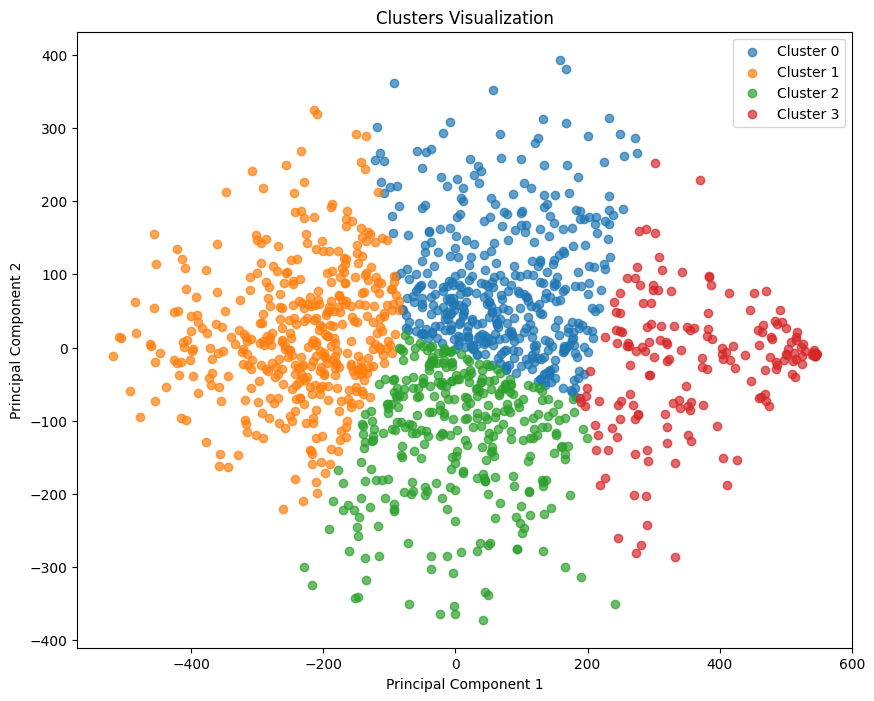

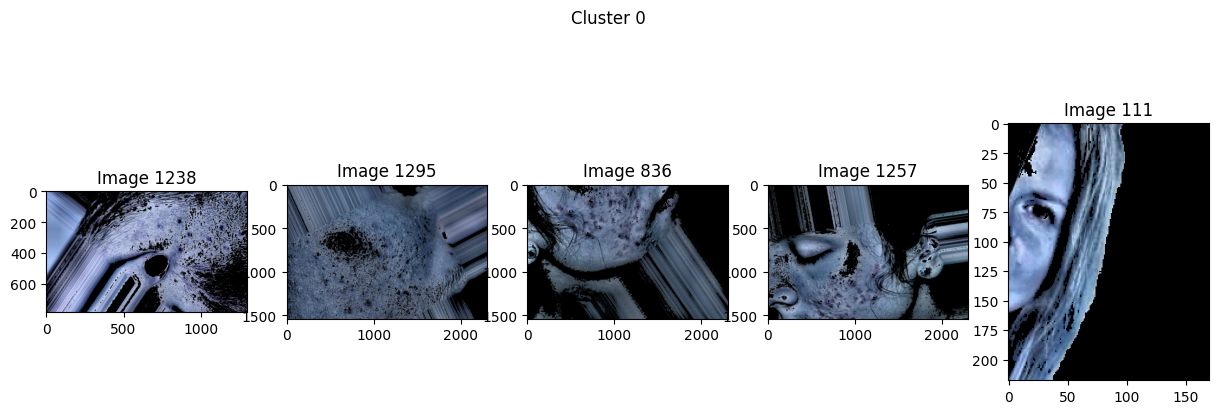

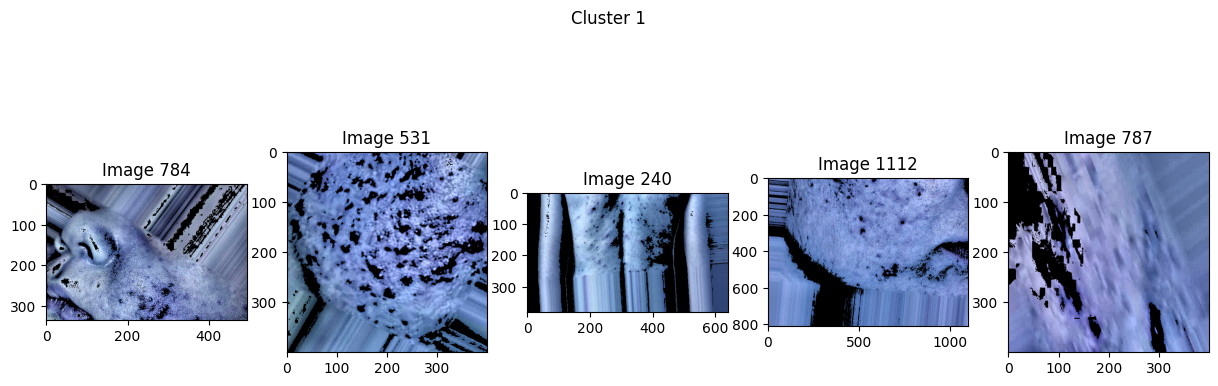

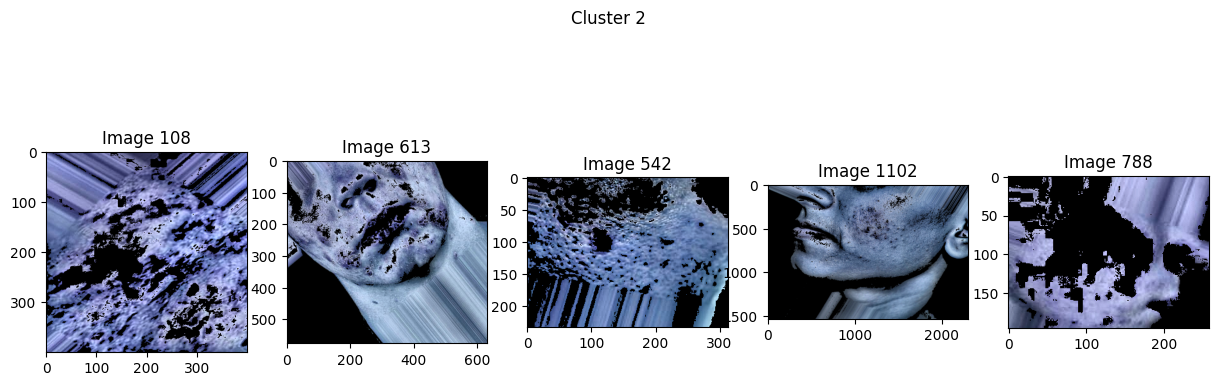

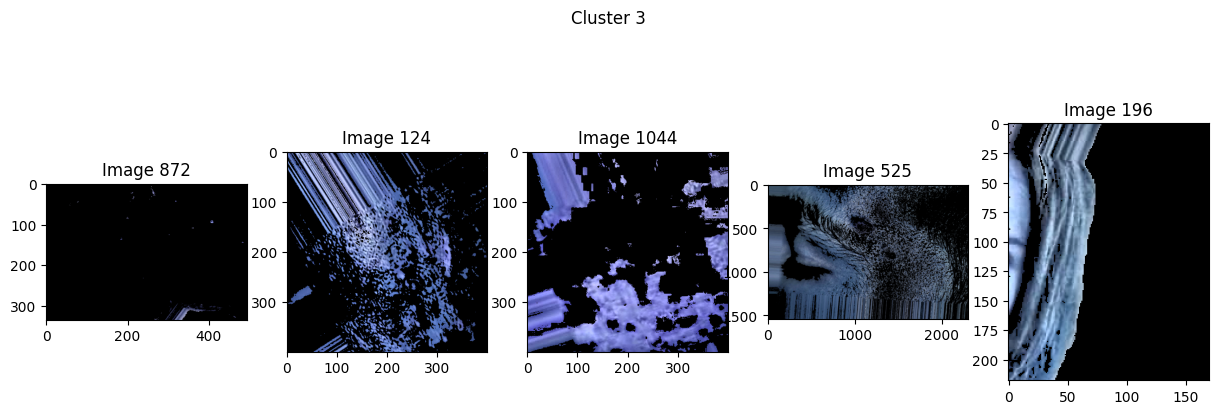

In [10]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def resize_and_flatten_image(image, target_size=(256, 256)):
    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)
    # Flatten the resized image content
    return resized_image.reshape(-1)

def cluster_images(csv_file, image_folder, num_clusters=4):
    # Load features from the CSV file
    data = pd.read_csv(csv_file)

    # Load skin-detected images from the folder
    skin_detected_images = []
    image_paths = []  # New list to store image paths

    for image_name in tqdm(data['image_name'], desc='Loading images'):
        image_path = os.path.join(image_folder, f'skin_detected_{image_name}.png')
        img = cv2.imread(image_path)
        resized_and_flattened = resize_and_flatten_image(img)
        skin_detected_images.append(resized_and_flattened)
        image_paths.append(image_path)

    # Convert the list of images to a NumPy array
    skin_detected_images_array = np.array(skin_detected_images)

    # Combine features from the CSV file and flattened image content
    combined_features = np.concatenate([data.iloc[:, :-2].values, skin_detected_images_array], axis=1)

    # Standardize the features
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(combined_features)

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(standardized_features)

    # Perform K-Means clustering on the principal components
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(principal_components)

    # Add cluster labels and image paths to the DataFrame
    data['cluster_label'] = cluster_labels
    data['image_path'] = image_paths

    # Display the mean values of oiliness-related features for each cluster
    oiliness_columns = ['feature_0', 'feature_1', 'feature_2', 'feature_3']  # Adjust these based on your features
    cluster_means = data.groupby('cluster_label')[oiliness_columns].mean()

    print("Mean Oiliness Levels for Each Cluster:")
    print(cluster_means)

    # Visualize the scatter plot of clusters
    plt.figure(figsize=(10, 8))
    plt.title('Clusters Visualization')

    for cluster_num in range(num_clusters):
        cluster_indices = data[data['cluster_label'] == cluster_num].index
        plt.scatter(
            principal_components[cluster_indices, 0],
            principal_components[cluster_indices, 1],
            label=f'Cluster {cluster_num}',
            alpha=0.7
        )

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

    # Visualize 5 images per cluster
    for cluster_num in range(num_clusters):
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Cluster {cluster_num}')

        # Get indices of images in the current cluster
        cluster_indices = data[data['cluster_label'] == cluster_num].index

        for i, idx in enumerate(np.random.choice(cluster_indices, min(5, len(cluster_indices)), replace=False)):
            plt.subplot(1, 5, i + 1)
            img_path = data["image_path"][idx]
            img = cv2.imread(img_path)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f'Image {idx}')

        plt.show()

    return data

# Specify the CSV file and image folder paths
csv_file_path = 'extracted_features.csv'
image_folder_path = '/content/extracted_feature_images'

# Call the clustering method
clustered_data = cluster_images(csv_file_path, image_folder_path, num_clusters=4)

# Optionally, you can save the clustered data to a new CSV file
clustered_data.to_csv('clustered_data.csv', index=False)



In [11]:
import pandas as pd

# Assuming you have the data in a CSV file named 'your_data.csv'
data = pd.read_csv('/content/clustered_data.csv')

# Grouping by 'cluster_label' and calculating mean for each cluster
cluster_means = data.groupby('cluster_label').mean()

# Mapping the clusters to skin oiliness levels
oiliness_levels = {
    0: 'Low',
    1: 'Medium',
    2: 'High',
    3: 'Very High'
}

# Adding a new column 'oiliness_level' based on cluster labels
cluster_means['oiliness_level'] = cluster_means.index.map(oiliness_levels)

# Displaying the resulting DataFrame
print(cluster_means)


               feature_0   feature_1   feature_2  feature_3  feature_4  \
cluster_label                                                            
0              26.367310  101.303906  159.887627  36.580959  38.482712   
1              13.127283  101.981647  195.413328  20.175620  32.879678   
2              22.867899  101.558269  169.848151  33.299567  39.131488   
3              65.750242   86.231446  159.716291  40.450418  36.228997   

               feature_5   feature_6  feature_7 oiliness_level  
cluster_label                                                   
0              47.754362  150.974940   8.458670            Low  
1              38.421103  156.485931   6.830275         Medium  
2              46.508446  152.769842   8.074064           High  
3              47.638564  146.630783   7.856818      Very High  


<ipython-input-11-4668c641ae17>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = data.groupby('cluster_label').mean()


In [13]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

17225924/17225924 [==============================] - 0s 0us/step
Found 1073 images belonging to 4 classes.
Found 269 images belonging to 4 classes.
Epoch 1/15
68/68 [==============================] - 78s 867ms/step - loss: 1.3898 - accuracy: 0.5536 - val_loss: 1.6398 - val_accuracy: 0.5353 - lr: 0.0010
Epoch 2/15
68/68 [==============================] - 50s 729ms/step - loss: 0.9129 - accuracy: 0.6384 - val_loss: 1.4909 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 3/15
68/68 [==============================] - 47s 701ms/step - loss: 0.8077 - accuracy: 0.6580 - val_loss: 0.9183 - val_accuracy: 0.6468 - lr: 0.0010
Epoch 4/15
68/68 [==============================] - 47s 689ms/step - loss: 0.7282 - accuracy: 0.6570 - val_loss: 1.1582 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 5/15
68/68 [==============================] - 47s 691ms/step - loss: 0.7301 - accuracy: 0.6673 - val_loss: 1.1447 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 6/15
68/68 [==============================] - 48s 714ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


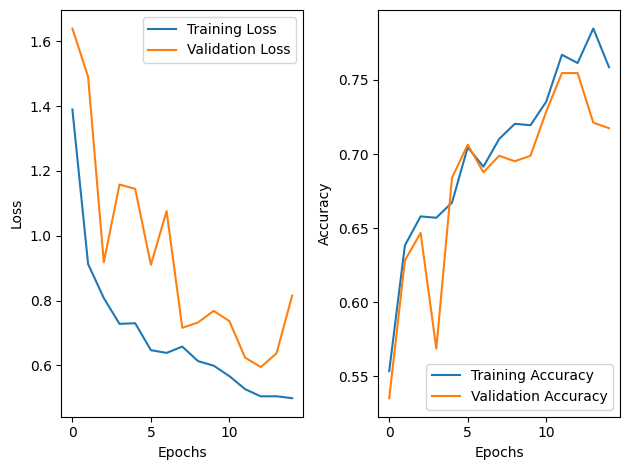

In [14]:
# Define function to train and validate MobileNet model
def train_and_validate_model(data, image_folder, batch_size=32, epochs=10, validation_split=0.2):
    # Create directories for training and validation
    train_dir = 'train_data'
    val_dir = 'val_data'

    for folder in [train_dir, val_dir]:
        for subfolder in ['Low', 'Medium', 'High', 'Very High']:
            os.makedirs(os.path.join(folder, subfolder), exist_ok=True)

    # Split data into training and validation sets
    train_data, val_data = train_test_split(data, test_size=validation_split, random_state=42)

    # Copy images to respective directories
    for idx, row in train_data.iterrows():
        img_path = row['image_path']
        oiliness_level = oiliness_levels[row['cluster_label']]
        shutil.copy(img_path, os.path.join(train_dir, oiliness_level))

    for idx, row in val_data.iterrows():
        img_path = row['image_path']
        oiliness_level = oiliness_levels[row['cluster_label']]
        shutil.copy(img_path, os.path.join(val_dir, oiliness_level))

    # Load MobileNet model with pre-trained weights
    base_model = MobileNet(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation='softmax')  # 4 classes: 'Low', 'Medium', 'High', 'Very High'
    ])

    # Compile the model with a learning rate scheduler
    def scheduler(epoch, lr):
        if epoch < 5:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Data augmentation for training set
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2
    )
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=batch_size, class_mode='categorical')

    # Data augmentation for validation set
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_directory(val_dir, target_size=(256, 256), batch_size=batch_size, class_mode='categorical')

    # Train the model
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[LearningRateScheduler(scheduler)])

    # Print overall model accuracy and loss
    train_loss, train_accuracy = model.evaluate(train_generator)
    val_loss, val_accuracy = model.evaluate(val_generator)

    print(f"Overall Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
    print(f"Overall Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Save the trained model
    model.save('mobile_net_oiliness_model.h5')

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the training and validation function
train_and_validate_model(clustered_data, image_folder_path, batch_size=16, epochs=15, validation_split=0.2)

# **Colab web Cam and Face Detection**

In [15]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [16]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [17]:
image_file = take_photo()

<IPython.core.display.Javascript object>

400 300


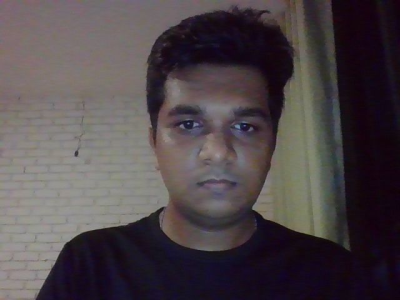

In [18]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

Downloading Pretrained Face Detection code

In [19]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2024-02-23 19:03:28--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2024-02-23 19:03:28 (16.0 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2024-02-23 19:03:28--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [20]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model_capture = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model_capture)

[INFO] loading model...


In [21]:
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [22]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


Cropped face 0 saved to /content/cropped_face_0.png


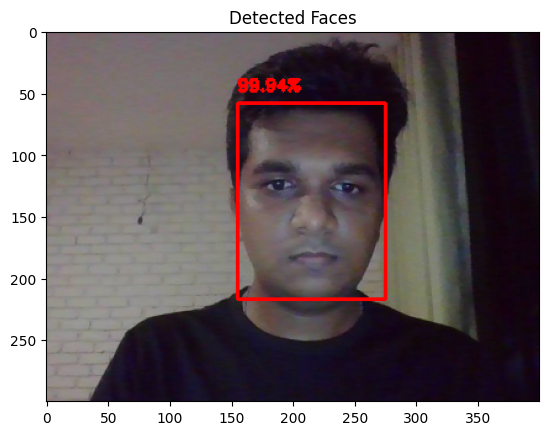

In [23]:

# Loop through each detected face
for i in range(0, detections.shape[2]):
    # Extract the confidence (probability) associated with the prediction
    confidence = detections[0, 0, i, 2]

    # Filter out weak detections by ensuring the confidence is greater than the minimum confidence threshold
    if confidence > 0.5:
        # Compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # Draw the bounding box of the face along with the associated probability
        text = "{:.2f}%".format(confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
        cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

        # Crop the face region from the original image
        cropped_face = image[startY:endY, startX:endX]

        # Save the cropped face as 'cropped_face_{i}.png' (or any other desired format)
        cropped_face_path = f'/content/cropped_face_{i}.png'
        cv2.imwrite(cropped_face_path, cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
        print(f"Cropped face {i} saved to {cropped_face_path}")

# Display the original image with bounding boxes and probabilities
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Faces')
plt.show()


# **Testing Image**

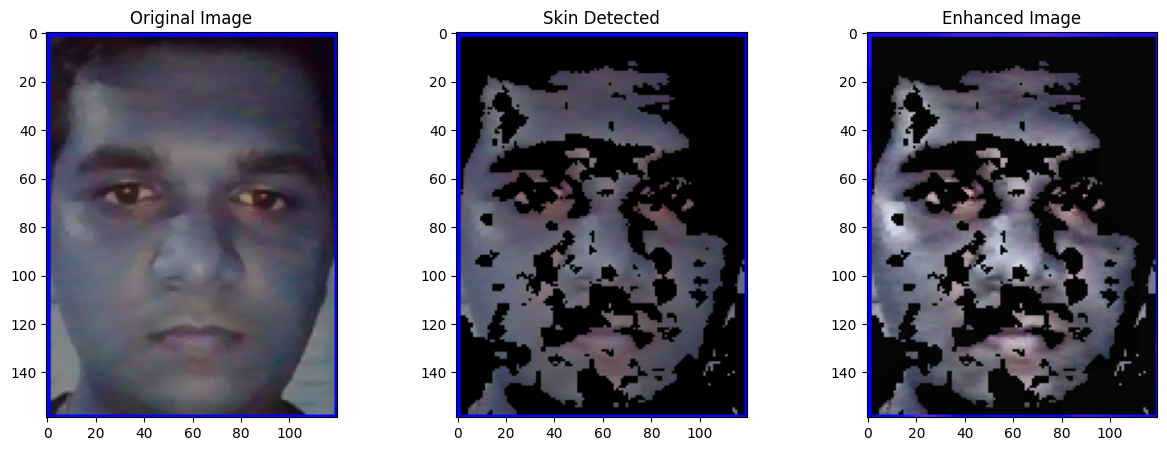

In [26]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to enhance skin texture using CLAHE
def enhance_skin_texture(image):
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Extract the L (luminance) channel
    l_channel = lab[:,:,0]

    # Apply CLAHE to enhance local contrast in the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l_channel = clahe.apply(l_channel)

    # Replace the original L channel with the enhanced one
    lab[:,:,0] = enhanced_l_channel

    # Convert the image back to BGR color space
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return enhanced_image

# Function for advanced skin detection
def advanced_skin_detection(image):
    # Apply advanced skin detection algorithm (modify as needed)
    # For example, you can use a pre-trained deep learning model for skin detection
    # Here, a simple thresholding approach is used as an example
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([108, 23, 82], dtype=np.uint8)
    upper_skin = np.array([179, 255, 255], dtype=np.uint8)
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)
    skin_detected = cv2.bitwise_and(image, image, mask=skin_mask)

    return skin_detected, skin_mask

# Specify the image path
image_path = '/content/cropped_face_0.png'

# Load the image
img = cv2.imread(image_path)

# Apply advanced skin detection
skin_detected, skin_mask = advanced_skin_detection(img)

# Enhance skin texture using CLAHE only on the skin pixels
enhanced_skin = enhance_skin_texture(skin_detected)

# Save the skin-detected and enhanced image as PNG in the '/content' directory
skin_detected_path = os.path.join('/content', 'skin_detected_and_enhanced_test.png')
cv2.imwrite(skin_detected_path, cv2.cvtColor(enhanced_skin, cv2.COLOR_BGR2RGB))

# View the original image, skin-detected image, and enhanced image
plt.figure(figsize=(15, 5))

# Display the original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# Display the skin-detected image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(skin_detected, cv2.COLOR_BGR2RGB))
plt.title('Skin Detected')

# Display the enhanced image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(enhanced_skin, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Image')

plt.show()



1/1 [==============================] - 1s 1s/step


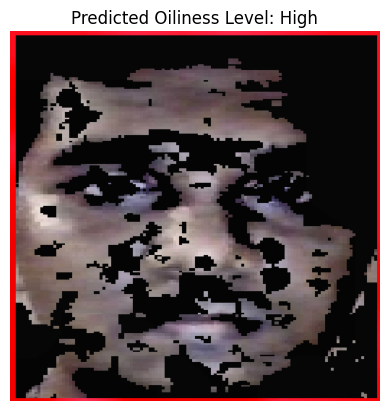

In [28]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained MobileNet model
trained_model = load_model('mobile_net_oiliness_model.h5')

# Function to predict oiliness level for a given image
def predict_oiliness(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained MobileNet model
    prediction = trained_model.predict(img_array)

    # Get the predicted oiliness level
    predicted_oiliness_level = oiliness_levels[np.argmax(prediction)]

    return img_array, predicted_oiliness_level  # Return img_array instead of img

# Example usage
image_path_to_check = '/content/skin_detected_and_enhanced_test.png'
img_array, predicted_oiliness = predict_oiliness(image_path_to_check)

# Display the image
plt.imshow(img_array[0]/255.0)  # Convert img_array to NumPy array before displaying
plt.title(f"Predicted Oiliness Level: {predicted_oiliness}")
plt.axis('off')
plt.show()

